In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from kwave.ktransducer import *
from kwave.utils import *
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.DAS import DAS
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import *
from utils.simulations import PSF, get_water_SoS, wavefront_real
from utils.utils_torch import get_fourier_coord
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load in Sinograms

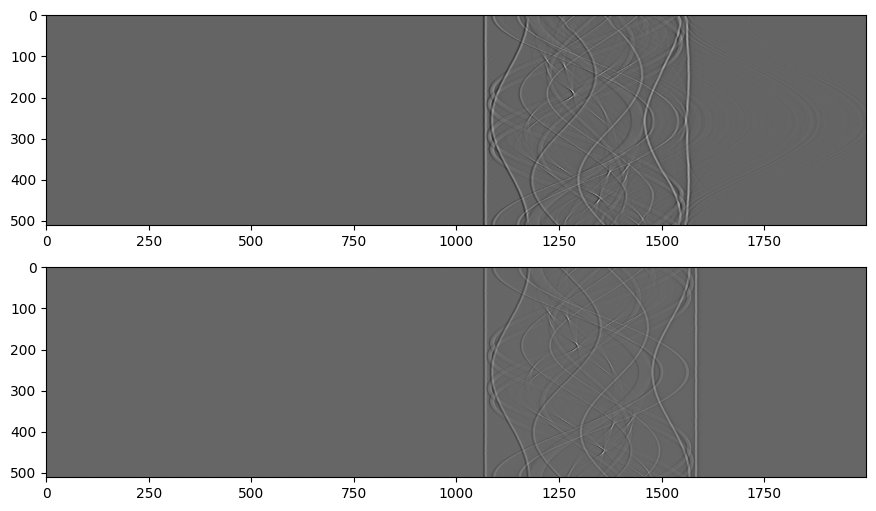

In [2]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram_uniform += np.random.normal(0, 1e-4, sinogram_uniform.shape)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Load and Deconvolve EIR

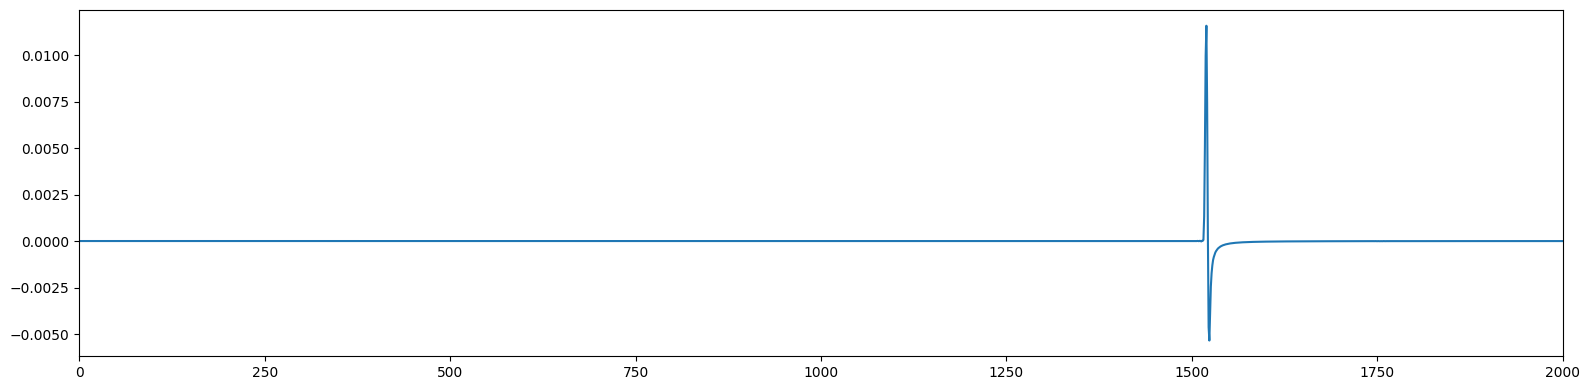

In [3]:
EIR = load_mat(os.path.join(data_path, 'EIR_KWAVE.mat'))

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

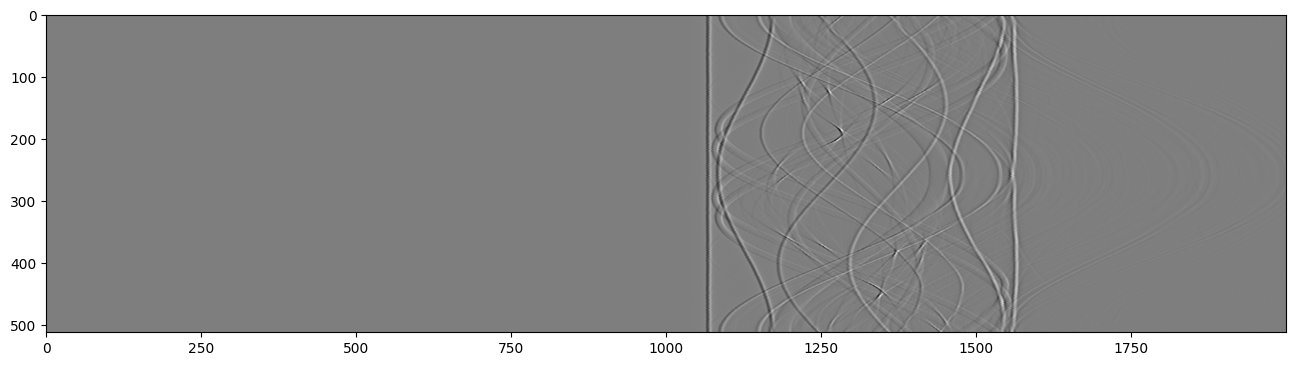

In [4]:
sinogram_deconv = deconvolve_sinogram(sinogram, EIR)

plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv, cmap='gray')
plt.show()

In [5]:
Nx, Ny = 560, 560
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [6]:
R = 9.9e-3 # Radius to center [m].
l = 3.2e-3 # Patch size [m].
T = 29.5 # Temperature of water [C].
v0 = get_water_SoS(T) # Background SoS [m/s].
v1 = 1564.4 # Avergae SoS in tissue [m/s].

print(v0, v1)

1508.0046878478038 1564.4


### Uniform SoS

In [7]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/(40e6), x_vec=kgrid.x_vec[:], y_vec=kgrid.y_vec[:], mode='zero')
das.to(device)
das.eval()

with torch.no_grad():
    gt = das(torch.tensor(sinogram_uniform).to(device), 1508).detach().cpu().numpy()
    
data = {'img': gt.swapaxes(0,1)}
save_mat(os.path.join(results_path, 'gt_simulation.mat'), data)

### Conventional DAS

In [8]:
with torch.no_grad():
    rec_das = das(torch.tensor(sinogram).to(device), 1517.6).detach().cpu().numpy()
    
data = {'img': rec_das.swapaxes(0,1)}
save_mat(os.path.join(results_path, 'das_simulation.mat'), data)

### APACT

In [33]:
delays_apact = np.arange(-8e-4, 8e-4, 1e-4)
recons = []
with torch.no_grad():
    for d_delay in delays_apact:
        recon = das(torch.tensor(sinogram).to(device), v0, d_delay).detach().cpu().numpy()
        recons.append(recon)
recons = np.array(recons)

In [34]:
l = 3.2e-3        
obss = []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        obs = torch.tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
        obss.append(obs)

In [35]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)

In [36]:
model = APACT(delays=delays_apact, dc_range=(0e-4, 4e-4), amp=3.2e-4, step=4e-5)
model.to(device)
model.eval()

rec_apact = np.zeros_like(recons[0])
for i in tqdm(range(25)):
    for j in tqdm(range(25)):
        obs = obss[i*25+j] * gaussian_window
        obs = obs.unsqueeze(0).to(device)
        with torch.no_grad():
            rec, _, _, _ = model(obs)
        rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
        rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec

100%|██████████| 25/25 [14:52<00:00, 35.72s/it]


Text(0.5, 1.0, 'Histogram')

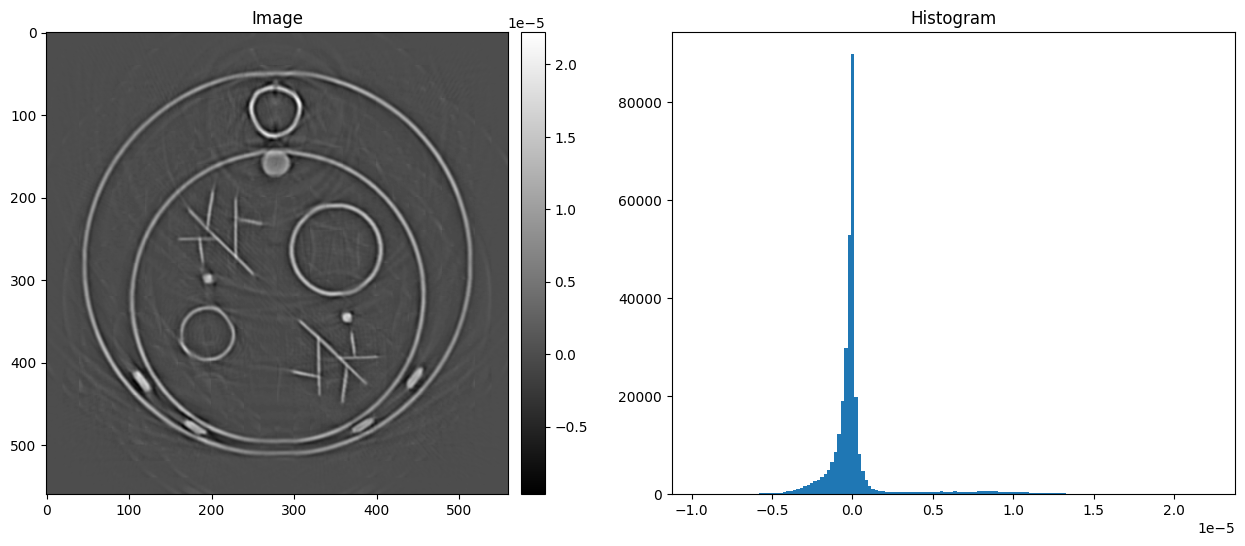

In [37]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(rec_apact, cmap='gray')
plt.title('Image', fontsize=12)
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)

ax2 = plt.subplot(1,2,2)
plt.hist(rec_apact.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

In [38]:
data = {'img': rec_apact.swapaxes(0,1)}
save_mat(os.path.join(results_path, 'apact_simulation.mat'), data)

### Deconvolution with Single Body PSFs

In [20]:
n_delays = 16
delays = get_delays(R, v0, v1, n_delays, 'uniform')
print(delays)

recons = []
with torch.no_grad():
    for d_delay in delays:
        recon = das(torch.tensor(sinogram).to(device), v0, d_delay, 1.e-6).detach().cpu().numpy()
        recons.append(recon)
recons = np.array(recons)

[0.00000000e+00 2.85509379e-05 5.71018758e-05 8.56528136e-05
 1.14203752e-04 1.42754689e-04 1.71305627e-04 1.99856565e-04
 2.28407503e-04 2.56958441e-04 2.85509379e-04 3.14060317e-04
 3.42611255e-04 3.71162192e-04 3.99713130e-04 4.28264068e-04]


In [21]:
l = 3.2e-3        
psfs = []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        x, y = (j-12)*l / 4, (12-i)*l / 4
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, r, phi, v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psfs.append(torch.stack(psf, dim=0))

In [22]:
wiener = Wiener_Batched(lam=0.03)
admm = ADMM_Batched(n_iters=16, lam=0.1, rho=0.03)

### Small Patch

In [23]:
i, j = 17, 15
# i, j = 12, 24
r, C0 = get_r_C0(i, j, R, l, v0, v1)
print('r={:.2f}mm   C0={:.2f}mm'.format(r*1e3, C0*1e3))

r=4.66mm   C0=0.34mm


In [24]:
# obs, psf = torch.Tensor(obss[i*25+j]), psfs[i*25+j]
# obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
# mean = obs.abs().mean()
# with torch.no_grad():
#     rec_wiener = wiener(obs/mean, psf) * mean
#     rec_admm = admm(obs/mean, psf) * mean
# obs = obs.squeeze(0).detach().cpu().numpy()
# psf = psf.squeeze(0).detach().cpu().numpy()
# rec_wiener = rec_wiener.squeeze(0).squeeze(0).detach().cpu().numpy()
# rec_wiener /= np.abs(rec_wiener).mean()
# rec_admm = rec_admm.squeeze(0).squeeze(0).detach().cpu().numpy()
# rec_admm /= np.abs(rec_admm).mean()

In [25]:
# plt.figure(figsize=(15,10))
# for idx in range(n_delays):
#     plt.subplot(5,8,idx+1)
#     plt.imshow(obs[idx], cmap='gray')
#     plt.title('Delay={:.2f}mm'.format(delays[idx]*1e3), fontsize=13)
#     plt.xticks([])
#     plt.yticks([])
#     if idx == 0:
#         plt.ylabel('Observation', fontsize=15)
    
#     plt.subplot(5,8,idx+n_delays+1)
#     plt.imshow(psf[idx], cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     if idx == 0:
#         plt.ylabel('PSF', fontsize=15)
    
# plt.subplot(5,8,3+2*n_delays)
# plt.imshow(rec_das[20*i:20*i+80, 20*j:20*j+80], cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('Conventional DAS', fontsize=15)

# plt.subplot(5,8,4+2*n_delays)
# plt.imshow(rec_wiener, cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('Wiener', fontsize=15)

# plt.subplot(5,8,5+2*n_delays)
# plt.imshow(rec_admm, cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('ADMM', fontsize=15)
    
# plt.tight_layout()

In [26]:
def deconv_full_img(model, recons, psfs, gaussian_window, delays, attention='uniform'):
    model.to(device)
    model.eval()
    
    rec_full = np.zeros_like(recons[0])
    for i in range(25):
        for j in range(25):
            obs = torch.tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
            psf = psfs[i*25+j]
            mean = obs.abs().mean()
            
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = get_weights(C0, delays, attention)
            obs, psf = obs * np.sqrt(weights), psf * np.sqrt(weights) # Apply attention weights to different channels.
            obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window
    return rec_full

rec_sb_wiener = deconv_full_img(wiener, recons, psfs, gaussian_window, delays)
rec_sb_admm = deconv_full_img(admm, recons, psfs, gaussian_window, delays)

data = {'img': rec_sb_wiener.swapaxes(0,1)}
save_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'), data)
data = {'img': rec_sb_admm.swapaxes(0,1)}
save_mat(os.path.join(results_path, 'sb_admm_simulation.mat'), data)

In [27]:
# img_list = []
# for v1 in [1560, 1562, 1564, 1566, 1568]:
#     for R in [9.6e-3, 9.7e-3, 9.8e-3, 9.9e-3, 10e-3]:
#         psfs = []
#         for i in range(25):
#             for j in range(25):
#                 x, y = (j-12)*l / 4, (12-i)*l / 4
#                 r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
#                 w_real = wavefront_real(R, r, phi, v0, v1)
#                 k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
#                 psf = []
#                 for _, delay in enumerate(delays):
#                     psf.append(PSF(theta2D, k2D, w_real, delay))
#                 psfs.append(torch.stack(psf, dim=0))
        
#         rec_sb_wiener = deconv_full_img(wiener, recons, psfs, gaussian_window, delays)
#         img_list.append(rec_sb_wiener)

In [28]:
# gt = normalize(gt)
# Rs = [9.6e-3, 9.7e-3, 9.8e-3, 9.9e-3, 10e-3]
# v1s = [1560, 1562, 1564, 1566, 1568]

# fig = plt.figure(figsize=(20,20))
# for i, R in enumerate(Rs):
#     for j, v1 in enumerate(v1s):
#         ax = plt.subplot(5,5,i*5+j+1)
#         img = normalize(img_list[i*5+j])
#         plt.imshow(img, cmap='gray')
#         if j == 0:
#             plt.ylabel('R={:.2f}mm'.format(R*1e3), fontsize=15)
#         if i == 0:
#             plt.title('v1={:.1f}m/s'.format(v1), fontsize=15)
#         plt.title('SSIM={:.3f}'.format(ssim(img, gt, data_range=1)), loc='left',x=0.01, y=0.0, color='white', fontsize=15)
#         plt.title('PSNR={:.1f}'.format(psnr(img, gt, data_range=1)), loc='right',x=0.98, y=0.0, color='white', fontsize=15)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout()

### Create Figure

Load and normalize images.

In [39]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation.mat'))
rec_sb_wiener = load_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'))    
rec_sb_admm = load_mat(os.path.join(results_path, 'sb_admm_simulation.mat'))

In [40]:
IP_img, gt, rec_das, rec_apact, rec_sb_wiener, rec_sb_admm = [normalize(img) for img in [IP_img, gt, rec_das, rec_apact, rec_sb_wiener, rec_sb_admm]]

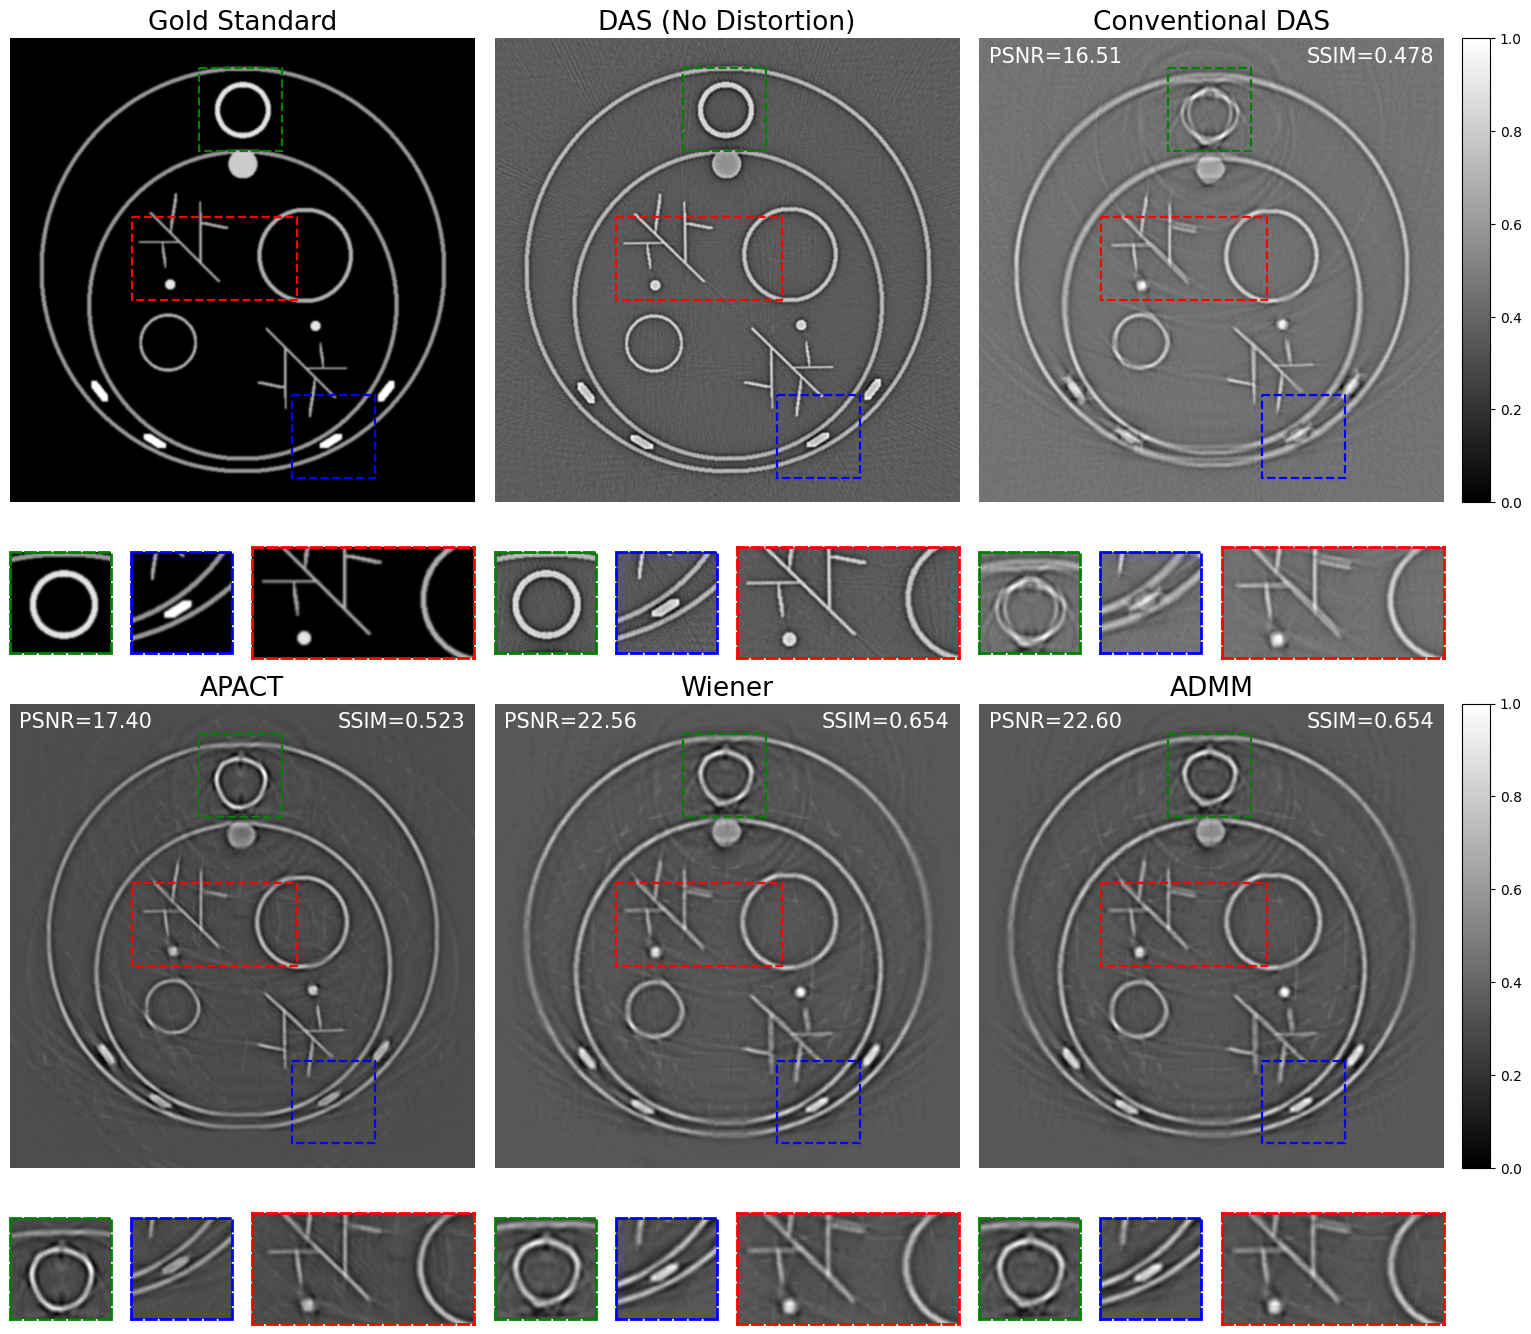

In [42]:
patches = [(36, 227, 100, 100, 'green'), (430, 340, 100, 100,'blue'), (216, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
norm = matplotlib.colors.Normalize(vmax=1, vmin=-0)
for idx, (rec_full, method) in enumerate(zip([IP_img, gt, rec_das, rec_apact, rec_sb_wiener, rec_sb_admm], ['Gold Standard', 'DAS (No Distortion)', 'Conventional DAS', 'APACT', 'Wiener', 'ADMM'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 1:
        plt.title('PSNR={:.2f}'.format(psnr(gt, rec_full, data_range=1)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(gt, rec_full, data_range=1)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

Compare different attention weights.

In [ ]:
# fig = plt.figure(figsize=(16, 10))
# norm = matplotlib.colors.Normalize(vmax=1, vmin=-0)
# for i, attention in enumerate(['uniform', 'euclidean', 'onehot']):
#     for j, mode in enumerate(['uniform', 'quadric']):
#         ax = plt.subplot(2,3,j*3+i+1)
#         delays = get_delays(R, v0, v1, n_delays, mode)
#         rec_full = deconv_full_img(wiener, recons, psfs, gaussian_window, delays, attention)
#         rec_full = normalize(rec_full)
#         plt.imshow(rec_full, cmap='gray', norm=norm)
#         if j == 0:
#             plt.title(attention, fontsize=20)
#         if i == 0:
#             plt.ylabel(mode, fontsize=20)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout()